In [1]:
import polars as pl
import numpy as np
from typing import List

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # ‰∫åÈò∂Â∑ÆÂàÜ = ‰∏ÄÈò∂Â∑ÆÂàÜÁöÑÂ∑ÆÂàÜ
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # Âä®ÈáèÊØîÁéá = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def lag_exprs(col: str, lags: List[int]) -> List[pl.Expr]:
    return [
        pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
        for lag in lags
    ]


def cross_comb_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) + (pl.col(b) + 1e-8)).alias(f"{a}_comb_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        )
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            diff_expr(col),
            second_order_diff_expr(col),
            momentum_ratio_expr(col, lag),
            rolling_volatility_expr(col, window),
        ])
        # single_exprs.extend(lag_exprs(col, [10, 20, 50, 100, 200]))

    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_comb_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(single_exprs)



In [2]:
from tqdm import tqdm

def split_df_by_month(
        df: pl.DataFrame,
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        df.filter(pl.col("month_start") == mo).drop("month_start")
        for mo in unique_months["month_start"]
    ]

    return monthly_dfs


def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("ÂêÑÂàóÁ©∫ÂÄºÊï∞ÈáèÔºö")
        print(null_counts[null_counts > 0])
        print(f"Âà†Èô§Á©∫ÂÄºË∂ÖËøá {null_threshold} ÁöÑÂàóÔºö{list(cols_to_drop)}")
        print(f"Âà†Èô§ÂàóÂêéÔºåDataFrameÂΩ¢Áä∂Ôºö{pd_df_cleaned.shape}")
        print(f"Á©∫ÂÄºÊúÄÂ§öÁöÑÂàóÊòØÔºö{max_null_col}ÔºåÂÖ±Êúâ {max_null_count} ‰∏™Á©∫ÂÄº")
        print(f"Âà†Èô§Á©∫ÂÄºË°åÂêéÔºåDataFrameÂΩ¢Áä∂Ôºö{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled ÊòØÊúÄÁªà‰∫ßÁâ©Ôºå‰øùÁïô
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window, min_samples=1)
        .tanh()
        .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    # feature_cols = [
    #     col for col in df.columns
    #     if col.endswith("_scaled") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank ËΩ¨Êç¢
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # Êõ¥Êñ∞ prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling2000.csv")
monthly_dataframes = split_df_by_month(origin_df)
print(monthly_dataframes)

[shape: (11_186, 118)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ px      ‚îÜ sum_buy_sz ‚îÜ sum_sell_sz ‚îÜ ‚Ä¶ ‚îÜ z_factor_order_sentim ‚îÜ z_factor_oi_momentum_ ‚îÜ z_factor_oi_momentum ‚îÜ timestamp_dt ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---        ‚îÜ ---         ‚îÜ   ‚îÜ ent_diver‚Ä¶            ‚îÜ punch                 ‚îÜ _long_term‚Ä¶          ‚îÜ ---          ‚îÇ
‚îÇ i64              ‚îÜ f64     ‚îÜ f64        ‚îÜ f64         ‚îÜ   ‚îÜ ---                   ‚îÜ ---                   ‚îÜ ---                  ‚îÜ datetime[Œºs] ‚îÇ
‚îÇ                  ‚îÜ 

In [4]:
mo_df = batch_apply_transforms(origin_df, 200, 10)
# mo_df = batch_apply_transforms(monthly_dataframes[-2], 500, 1)

# mo_df = origin_df
print(f"Polars DataFrame size: {mo_df.estimated_size() / (1024 ** 2):.4f} MB")

prices_np = mo_df["px"].to_numpy()[:20000]
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02) 
# avg_steps_5pct = avg_steps_to_volatility(prices_np, 0.05)
avg_steps_2pct = 127
print("Ê≥¢Âä® ¬±0.5% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_05pct)
print("Ê≥¢Âä® ¬±1% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_1pct)
print("Ê≥¢Âä® ¬±2% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_2pct)
# print("Ê≥¢Âä® ¬±5% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_5pct)

# cal future ret
mo_df = mo_df.with_columns([
    future_return_expr("px", avg_steps_05pct),
    future_return_expr("px", avg_steps_1pct),
    future_return_expr("px", avg_steps_2pct),
    # future_return_expr("px", avg_steps_5pct),

])
print(mo_df)

mo_df = rolling_mean_tanh_normalize(mo_df, 200)

mo_df = clean_df_drop_nulls(mo_df)



Polars DataFrame size: 115.5612 MB


cal abs change 2.00% avg steps: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20000/20000 [00:01<00:00, 14338.08it/s]


Ê≥¢Âä® ¬±0.5% ÁöÑÂùáÂÄºÊ≠•Êï∞: 27
Ê≥¢Âä® ¬±1% ÁöÑÂùáÂÄºÊ≠•Êï∞: 99
Ê≥¢Âä® ¬±2% ÁöÑÂùáÂÄºÊ≠•Êï∞: 127
shape: (26_008, 580)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ px       ‚îÜ sum_buy_sz ‚îÜ sum_sell_sz ‚îÜ ‚Ä¶ ‚îÜ z_factor_oi_momentum_lon ‚îÜ future_return_27 ‚îÜ future_return_99 ‚îÜ future_return_127 ‚îÇ
‚îÇ ---              ‚îÜ ---      ‚îÜ ---        ‚îÜ ---         ‚îÜ   ‚îÜ g_term‚Ä¶                  ‚îÜ ---              ‚îÜ ---              ‚îÜ ---               ‚îÇ
‚îÇ i64              ‚îÜ f64      ‚îÜ f64        ‚îÜ f64         ‚îÜ   ‚îÜ ---                    

In [117]:
mo_df_secs = mo_df.with_columns(
    (pl.col("ts_duration") / 1_000_000).alias("ts_duration_secs")
)

mo_df_secs.select("ts_duration_secs").describe()

shape: (9, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ ts_duration_secs ‚îÇ
‚îÇ ---        ‚îÜ ---              ‚îÇ
‚îÇ str        ‚îÜ f64              ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 25682.0          ‚îÇ
‚îÇ null_count ‚îÜ 0.0              ‚îÇ
‚îÇ mean       ‚îÜ 236.339712       ‚îÇ
‚îÇ std        ‚îÜ 421.903417       ‚îÇ
‚îÇ min        ‚îÜ 0.0              ‚îÇ
‚îÇ 25%        ‚îÜ 28.094           ‚îÇ
‚îÇ 50%        ‚îÜ 94.764           ‚îÇ
‚îÇ 75%        ‚îÜ 265.49           ‚îÇ
‚îÇ max        ‚îÜ 12235.291        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [6]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_2pct}"
print(mo_df)


shape: (25_682, 1_155)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ px       ‚îÜ sum_buy_sz ‚îÜ sum_sell_sz ‚îÜ ‚Ä¶ ‚îÜ z_factor_oi_momentu ‚îÜ z_factor_oi_moment ‚îÜ z_factor_oi_moment ‚îÜ z_factor_oi_moment ‚îÇ
‚îÇ ---              ‚îÜ ---      ‚îÜ ---        ‚îÜ ---         ‚îÜ   ‚îÜ m_long_term‚Ä¶        ‚îÜ um_long_term‚Ä¶      ‚îÜ um_long_term‚Ä¶      ‚îÜ um_long_term‚Ä¶      ‚îÇ
‚îÇ i64              ‚îÜ f64      ‚îÜ f64        ‚îÜ f64         ‚îÜ   ‚îÜ ---                 ‚îÜ ---                ‚îÜ ---                ‚îÜ ---                ‚îÇ
‚îÇ                  

In [99]:
from scipy.stats import spearmanr

df = mo_df.to_pandas()

ic_list = []

for col in df.columns:
    if "_scaled" in col:
        ic = spearmanr(df[col], df[target_col], nan_policy='omit')[0]
        ic_list.append((col, ic))

# ÊåâÁÖß IC ‰ªéÂ§ßÂà∞Â∞èÊéíÂ∫èÂπ∂ËæìÂá∫
sorted_ic = sorted(ic_list, key=lambda x: abs(x[1]), reverse=True)

for col, ic in sorted_ic:
    print(f"{col:<30} IC: {ic:.4f}")


C:\Users\Grayman\AppData\Local\Temp\ipykernel_80372\44192374.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(df[col], df[target_col], nan_policy='omit')[0]


ts_duration_scaled             IC: nan
z_factor_long_term_oi_volatility_volatility_200_scaled IC: -0.1816
z_oi_up_divergence_short_term_scaled IC: 0.1639
z_factor_long_term_oi_trend_volatility_200_scaled IC: -0.1632
trade_taker_buySellRatio_volatility_200_scaled IC: -0.1478
factor_momentum_trend_confirm_scaled IC: 0.1438
z_factor_momentum_trend_confirm_scaled IC: 0.1380
z_factor_impact_momentum_scaled IC: 0.1262
z_factor_orderflow_sz_momentum_scaled IC: 0.1089
z_oi_di_scaled                 IC: 0.1064
z_factor_order_sentiment_divergence_scaled IC: 0.1022
factor_orderflow_sz_momentum_scaled IC: 0.0958
z_factor_impact_sensitivity_scaled IC: 0.0869
acc_longShortRatio_scaled      IC: 0.0823
z_oi_down_divergence_scaled    IC: 0.0821
factor_oi_breakout_signal_scaled IC: 0.0787
factor_impact_momentum_scaled  IC: 0.0749
oi_di_long_term_scaled         IC: -0.0741
oi_di_scaled                   IC: 0.0700
top_acc_longShortRatio_scaled  IC: 0.0694
trade_taker_buy_vol_scaled     IC: nan
trade_take

AttributeError: 'Series' object has no attribute 'destribe'

In [105]:
df["z_factor_long_term_oi_volatility_volatility_200_scaled"].describe()

count    25682.000000
mean         0.827938
std          0.150936
min          0.029304
25%          0.802183
50%          0.884510
75%          0.921720
max          0.977511
Name: z_factor_long_term_oi_volatility_volatility_200_scaled, dtype: float64

In [8]:
ic_df = rolling_ic_ir_icto_index(
    mo_df,
    target_col=target_col,
    exclude_prefixes=exclude_prefixes,
    window_size=10000,
    step=100,  # ÊªëÁ™óÊ≠•Èïø
)
print(ic_df)

Rolling IC & ICTO:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                    | 92/157 [00:05<00:03, 16.47it/s]

KeyboardInterrupt



In [ ]:
adf = ic_df.to_pandas().dropna()
adf


In [ ]:
print(ic_df.sort("mean_ic"))

In [ ]:
selected_factors = adf["factor"].to_list()
print(selected_factors[:20])

In [ ]:
print(mo_df["z_taker_px_pct_diff"])

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def filter_by_mutual_info(df: pl.DataFrame, factor_cols: list[str], target_col: str, top_k: int = 50) -> list[str]:
    X = np.column_stack([df[col].to_numpy() for col in factor_cols])
    y = df[target_col].to_numpy()

    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    sorted_idx = np.argsort(mi_scores)[::-1]
    selected = [factor_cols[i] for i in sorted_idx[:top_k]]

    return selected

# final_selected_factors = filter_by_mutual_info(mo_df, selected_cols, target_col=target_col, top_k=30)
# print(final_selected_factors)

In [ ]:
import polars as pl
import matplotlib.pyplot as plt

def plot_factor_price_target(
    df: pl.DataFrame,
    factor_name: str,
    price_col: str,
    target_col: str,
    n: int = 300
):
    df_plot = df.select([price_col, factor_name, target_col]).tail(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_name, color="tab:red")
    ax2.plot(df_plot[factor_name], color="tab:red", alpha=0.6, label=factor_name)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))  # Á¨¨‰∏â‰∏™yËΩ¥ÂæÄÂè≥ÂÅèÁßª
    ax3.set_ylabel(target_col, color="tab:green")
    ax3.plot(df_plot[target_col], color="tab:green", alpha=0.5, linestyle="--", label=target_col)
    ax3.tick_params(axis="y", labelcolor="tab:green")

    plt.title(f"{factor_name} vs {price_col} vs {target_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

def z_score_expr(col_name: str, window: int) -> pl.Expr:
    return (
            (pl.col(col_name) - pl.col(col_name)
             .rolling_mean(window, min_samples=1)
             .fill_null(strategy="zero"))
            / (pl.col(col_name)
               .rolling_std(window, min_samples=1)
               .fill_nan(0) + 1e-6)
    ).fill_null(0).alias(f"z_{col_name}")
    
# mo_df = rolling_mean_tanh_normalize(mo_df, 200)

# mo_df = clean_df_drop_nulls(mo_df)

plot_factor_price_target(
    df=mo_df.with_columns([
        z_score_expr("raw_factor_long_term_oi_trend", 200),
    ]),
    factor_name="z_bs_ratio_rol_mean_2000_scaled",
    price_col="px",
    target_col="oi_di_long_term_scaled",  # ‰πüÂèØ‰ª•ÊîπÊàêÂà´ÁöÑ targetÔºåÊØîÂ¶ÇÊñπÂêëÊ†áÁ≠æ
    n=47600
)


ÂêÑÂàóÁ©∫ÂÄºÊï∞ÈáèÔºö
Series([], dtype: int64)
Âà†Èô§Á©∫ÂÄºË∂ÖËøá 10000 ÁöÑÂàóÔºö[]
Âà†Èô§ÂàóÂêéÔºåDataFrameÂΩ¢Áä∂Ôºö(25682, 1155)
Á©∫ÂÄºÊúÄÂ§öÁöÑÂàóÊòØÔºötimestampÔºåÂÖ±Êúâ 0 ‰∏™Á©∫ÂÄº
Âà†Èô§Á©∫ÂÄºË°åÂêéÔºåDataFrameÂΩ¢Áä∂Ôºö(25682, 1155)


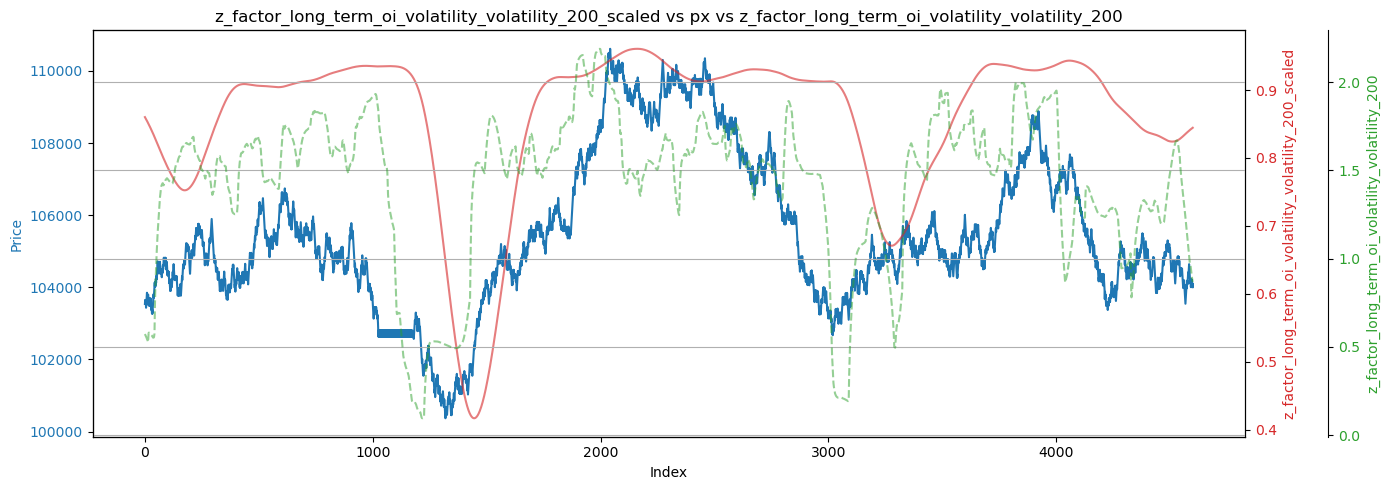

In [111]:
import polars as pl
import matplotlib.pyplot as plt

def plot_factor_price_target(
    df: pl.DataFrame,
    factor_name: str,
    price_col: str,
    target_col: str,
    n: int = 300
):
    df_plot = df.select([price_col, factor_name, target_col]).tail(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_name, color="tab:red")
    ax2.plot(df_plot[factor_name], color="tab:red", alpha=0.6, label=factor_name)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))  # Á¨¨‰∏â‰∏™yËΩ¥ÂæÄÂè≥ÂÅèÁßª
    ax3.set_ylabel(target_col, color="tab:green")
    ax3.plot(df_plot[target_col], color="tab:green", alpha=0.5, linestyle="--", label=target_col)
    ax3.tick_params(axis="y", labelcolor="tab:green")

    plt.title(f"{factor_name} vs {price_col} vs {target_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

mo_df = rolling_mean_tanh_normalize(mo_df, 200)

mo_df = clean_df_drop_nulls(mo_df)

plot_factor_price_target(
    df=mo_df.with_columns([
        (pl.col("z_factor_impact_momentum") + pl.col("z_factor_oi_trend_slope")).rolling_mean(300).tanh()
        .alias("pread")
    ]),
    factor_name="z_factor_long_term_oi_volatility_volatility_200_scaled",
    price_col="px",
    target_col="z_factor_long_term_oi_volatility_volatility_200",  # ‰πüÂèØ‰ª•ÊîπÊàêÂà´ÁöÑ targetÔºåÊØîÂ¶ÇÊñπÂêëÊ†áÁ≠æ
    n=4600
)


In [ ]:
import polars as pl
import matplotlib.pyplot as plt

def plot_price_and_factor_mean(
    df: pl.DataFrame,
    price_col: str,
    factor_mean_col: str,
    n: int = 300
):
    # ÂÖàÈÄâÊã©ÈúÄË¶ÅÁöÑÂàóÔºåÂèñÊúÄÂêénÊù°ÔºåËΩ¨Êàêpandas
    df_plot = df.select([price_col, factor_mean_col]).head(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_mean_col, color="tab:orange")
    ax2.plot(df_plot[factor_mean_col], color="tab:orange", linestyle="--", alpha=0.6, label="Factor Mean")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    plt.title(f"{price_col} vs {factor_mean_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()


mo_df = mo_df.with_columns(
    pl.mean_horizontal(selected_factors).alias("factor_mean")
)

# Á°ÆËÆ§Êï∞ÊçÆ
print(mo_df.head())

# Ë∞ÉÁî®ÁªòÂõæÂáΩÊï∞Ôºå‰º†ÂÖ•Âê´Êúâ px Âíå factor_mean ÁöÑ DataFrame
plot_price_and_factor_mean(
    df=mo_df,
    price_col="px",            # ‰Ω†Ë¶ÅÁîªÁöÑ‰ª∑Ê†ºÂàó
    factor_mean_col="factor_mean",
    n=96000
)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "raw_factor_long_term_oi_trend_scaled",
    upper_q: float = 0.9,
    lower_q: float = 0.1,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower

    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === ‰ªì‰ΩçÈÄªËæë & Êî∂ÁõäËÆ°ÁÆóÁï•Ôºå‰øùÊåÅ‰∏çÂèò ===
    # ‰ª•‰∏ãÈÉ®ÂàÜÂíå‰Ω†ÂéüÊù•ÁöÑÈÄªËæë‰∏ÄËá¥ÔºàÁï•ÂéªÈáçÂ§çÈÉ®ÂàÜÔºâ

    # ‰ªì‰ΩçËÆ°ÁÆó
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # ËÉúÁéáÁªüËÆ°
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # ÊúÄÂ§ßÂõûÊí§
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Á≠ñÁï•ÂíåbenchmarkÁ¥ØËÆ°Êî∂Áõä
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # ÂºÄ‰ªì/Âπ≥‰ªìÁÇπ
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # ‰ªì‰ΩçÂõæ
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = mo_df.select(["px", "raw_factor_long_term_oi_trend_scaled"]).to_pandas()

# Ë∂ãÂäøÁ≠ñÁï•
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=True, window=500)
plot_strategy(trend_df_roll, mode="trend")

# # ÂõûÂΩíÁ≠ñÁï•
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=True, window=500)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling200.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.9,
    lower_q: float = 0.1,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower

    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === ‰ªì‰ΩçÈÄªËæë & Êî∂ÁõäËÆ°ÁÆóÁï•Ôºå‰øùÊåÅ‰∏çÂèò ===
    # ‰ª•‰∏ãÈÉ®ÂàÜÂíå‰Ω†ÂéüÊù•ÁöÑÈÄªËæë‰∏ÄËá¥ÔºàÁï•ÂéªÈáçÂ§çÈÉ®ÂàÜÔºâ

    # ‰ªì‰ΩçËÆ°ÁÆó
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # ËÉúÁéáÁªüËÆ°
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # ÊúÄÂ§ßÂõûÊí§
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Á≠ñÁï•ÂíåbenchmarkÁ¥ØËÆ°Êî∂Áõä
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # ÂºÄ‰ªì/Âπ≥‰ªìÁÇπ
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # ‰ªì‰ΩçÂõæ
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = mo_df.select(["px", "factor_mean"]).to_pandas()

# Ë∂ãÂäøÁ≠ñÁï•
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=True, window=500)
plot_strategy(trend_df_roll, mode="trend")

# # ÂõûÂΩíÁ≠ñÁï•
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=True, window=500)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling200.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.9,
    lower_q: float = 0.1,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower

    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === ‰ªì‰ΩçÈÄªËæë & Êî∂ÁõäËÆ°ÁÆóÁï•Ôºå‰øùÊåÅ‰∏çÂèò ===
    # ‰ª•‰∏ãÈÉ®ÂàÜÂíå‰Ω†ÂéüÊù•ÁöÑÈÄªËæë‰∏ÄËá¥ÔºàÁï•ÂéªÈáçÂ§çÈÉ®ÂàÜÔºâ

    # ‰ªì‰ΩçËÆ°ÁÆó
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # ËÉúÁéáÁªüËÆ°
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # ÊúÄÂ§ßÂõûÊí§
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Á≠ñÁï•ÂíåbenchmarkÁ¥ØËÆ°Êî∂Áõä
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # ÂºÄ‰ªì/Âπ≥‰ªìÁÇπ
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # ‰ªì‰ΩçÂõæ
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = mo_df.select(["px", "factor_mean"]).to_pandas()

# Ë∂ãÂäøÁ≠ñÁï•
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=True, window=5000)
plot_strategy(trend_df_roll, mode="trend")

# # ÂõûÂΩíÁ≠ñÁï•
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=True, window=5000)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/GUNUSDT_factors_threshold0.002_rolling200.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.9,
    lower_q: float = 0.1,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower

    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === ‰ªì‰ΩçÈÄªËæë & Êî∂ÁõäËÆ°ÁÆóÁï•Ôºå‰øùÊåÅ‰∏çÂèò ===
    # ‰ª•‰∏ãÈÉ®ÂàÜÂíå‰Ω†ÂéüÊù•ÁöÑÈÄªËæë‰∏ÄËá¥ÔºàÁï•ÂéªÈáçÂ§çÈÉ®ÂàÜÔºâ

    # ‰ªì‰ΩçËÆ°ÁÆó
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # ËÉúÁéáÁªüËÆ°
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # ÊúÄÂ§ßÂõûÊí§
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Á≠ñÁï•ÂíåbenchmarkÁ¥ØËÆ°Êî∂Áõä
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # ÂºÄ‰ªì/Âπ≥‰ªìÁÇπ
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # ‰ªì‰ΩçÂõæ
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = mo_df.select(["px", "factor_mean"]).to_pandas()

# Ë∂ãÂäøÁ≠ñÁï•
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=True, window=500)
plot_strategy(trend_df_roll, mode="trend")

# # ÂõûÂΩíÁ≠ñÁï•
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=True, window=500)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/FILUSDT_factors_threshold0.002_rolling200.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.9,
    lower_q: float = 0.1,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower

    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === ‰ªì‰ΩçÈÄªËæë & Êî∂ÁõäËÆ°ÁÆóÁï•Ôºå‰øùÊåÅ‰∏çÂèò ===
    # ‰ª•‰∏ãÈÉ®ÂàÜÂíå‰Ω†ÂéüÊù•ÁöÑÈÄªËæë‰∏ÄËá¥ÔºàÁï•ÂéªÈáçÂ§çÈÉ®ÂàÜÔºâ

    # ‰ªì‰ΩçËÆ°ÁÆó
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # ËÉúÁéáÁªüËÆ°
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # ÊúÄÂ§ßÂõûÊí§
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Á≠ñÁï•ÂíåbenchmarkÁ¥ØËÆ°Êî∂Áõä
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # ÂºÄ‰ªì/Âπ≥‰ªìÁÇπ
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # ‰ªì‰ΩçÂõæ
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = mo_df.select(["px", "factor_mean"]).to_pandas()

# Ë∂ãÂäøÁ≠ñÁï•
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=True, window=500)
plot_strategy(trend_df_roll, mode="trend")

# # ÂõûÂΩíÁ≠ñÁï•
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=True, window=500)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/SOLUSDT_factors_threshold0.002_rolling200.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.9,
    lower_q: float = 0.1,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower

    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === ‰ªì‰ΩçÈÄªËæë & Êî∂ÁõäËÆ°ÁÆóÁï•Ôºå‰øùÊåÅ‰∏çÂèò ===
    # ‰ª•‰∏ãÈÉ®ÂàÜÂíå‰Ω†ÂéüÊù•ÁöÑÈÄªËæë‰∏ÄËá¥ÔºàÁï•ÂéªÈáçÂ§çÈÉ®ÂàÜÔºâ

    # ‰ªì‰ΩçËÆ°ÁÆó
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # ËÉúÁéáÁªüËÆ°
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # ÊúÄÂ§ßÂõûÊí§
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Á≠ñÁï•ÂíåbenchmarkÁ¥ØËÆ°Êî∂Áõä
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # ÂºÄ‰ªì/Âπ≥‰ªìÁÇπ
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # ‰ªì‰ΩçÂõæ
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = mo_df.select(["px", "factor_mean"]).to_pandas()

# Ë∂ãÂäøÁ≠ñÁï•
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=True, window=500)
plot_strategy(trend_df_roll, mode="trend")

# # ÂõûÂΩíÁ≠ñÁï•
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=True, window=500)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling200.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.95,
    lower_q: float = 0.05,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower

    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === ‰ªì‰ΩçÈÄªËæë & Êî∂ÁõäËÆ°ÁÆóÁï•Ôºå‰øùÊåÅ‰∏çÂèò ===
    # ‰ª•‰∏ãÈÉ®ÂàÜÂíå‰Ω†ÂéüÊù•ÁöÑÈÄªËæë‰∏ÄËá¥ÔºàÁï•ÂéªÈáçÂ§çÈÉ®ÂàÜÔºâ

    # ‰ªì‰ΩçËÆ°ÁÆó
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # ËÉúÁéáÁªüËÆ°
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # ÊúÄÂ§ßÂõûÊí§
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Á≠ñÁï•ÂíåbenchmarkÁ¥ØËÆ°Êî∂Áõä
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # ÂºÄ‰ªì/Âπ≥‰ªìÁÇπ
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # ‰ªì‰ΩçÂõæ
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = mo_df.select(["px", "factor_mean"]).to_pandas()

# Ë∂ãÂäøÁ≠ñÁï•
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=True, window=1000)
plot_strategy(trend_df_roll, mode="trend")

# # ÂõûÂΩíÁ≠ñÁï•
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=True, window=1000)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/FILUSDT_factors_threshold0.002_rolling200.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.9,
    lower_q: float = 0.1,
    mode: str = "trend"
) -> pd.DataFrame:
    df = df.copy()

    upper = df[factor_col].quantile(upper_q)
    lower = df[factor_col].quantile(lower_q)

    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > upper, 1,
                         np.where(df[factor_col] < lower, -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > upper, -1,
                         np.where(df[factor_col] < lower, 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # ‰ªì‰ΩçËÆ°ÁÆó
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # ËÉúÁéáÁªüËÆ°
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # ÊúÄÂ§ßÂõûÊí§
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    # Êó•Âøó
    print(f"\n=== Strategy Summary ({mode.upper()}) ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    # ‰øùÂ≠òÂºÄ/Âπ≥‰ªìÁÇπ
    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Á≠ñÁï•ÂíåbenchmarkÁ¥ØËÆ°Êî∂Áõä
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # ÂºÄ‰ªì/Âπ≥‰ªìÁÇπ
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # ‰ªì‰ΩçÂõæ
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = mo_df.select(["px", "factor_mean"]).to_pandas()

# Ë∂ãÂäøÁ≠ñÁï•
trend_df = strategy_with_position_logic(df_plot, mode="trend")
plot_strategy(trend_df, mode="trend")

# # ÂõûÂΩíÁ≠ñÁï•
revert_df = strategy_with_position_logic(df_plot, mode="mean_reversion")
plot_strategy(revert_df, mode="mean_reversion")


In [ ]:
import polars as pl
import pandas as pd

def time_split(
    df: pl.DataFrame,
    feature_cols: list[str],
    target_col: str,
    split_ratio: float = 0.7
):
    # ÊéíÂ∫èÂπ∂ÂéªÈô§Áº∫Â§±Ôºå‰øùËØÅ px Âàó‰πüË¢´‰øùÁïô
    df = df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()

    n = df.shape[0]
    split_point = int(n * split_ratio)

    df_train = df.iloc[:split_point]
    df_test = df.iloc[split_point:]

    X_train = df_train[feature_cols]
    y_train = df_train[target_col]
    px_train = df_train['px']  # ‰ª∑Ê†ºËÆ≠ÁªÉÈõÜ

    X_test = df_test[feature_cols]
    y_test = df_test[target_col]
    px_test = df_test['px']    # ‰ª∑Ê†ºÊµãËØïÈõÜ

    return X_train, y_train, px_train, X_test, y_test, px_test


In [ ]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_1pct}"
# selected_factors

In [ ]:
fct = ["z_factor_sentiment_net_scaled"]

In [ ]:
X_train, y_train, px_train, X_test, y_test, px_test = time_split(mo_df, selected_factors, target_col)
print(X_train)

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd # ÂÅáËÆæy_train, y_testÊòØpandas SeriesÔºå‰∏∫‰∫ÜÁ§∫‰æã

# Á§∫‰æãÊï∞ÊçÆÔºàÊ®°ÊãüÊúâÊ≠£ÊúâË¥üÁöÑÊî∂ÁõäÁéáÔºâ
# np.random.seed(42)
# y_train = pd.Series(np.concatenate([np.random.randn(50)*0.005 + 0.015, np.random.randn(50)*0.005 - 0.01]))
# y_test = pd.Series(np.concatenate([np.random.randn(20)*0.006 + 0.02, np.random.randn(20)*0.006 - 0.005]))


y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(y_train_np.reshape(-1, 1))

# Ëé∑Âèñ GMM ÂàÜÈáèÁöÑÂùáÂÄº
means = gmm.means_.flatten()

# Á°ÆÂÆöÂì™‰∏™ GMM ÂÜÖÈÉ®Ê†áÁ≠æ‰ª£Ë°®‰∏äÊ∂®ÔºàÂùáÂÄºÊõ¥Â§ßÁöÑÈÇ£‰∏™Ôºâ
upward_gmm_label = np.argmax(means)
downward_gmm_label = np.argmin(means) # ‰πüÂèØ‰ª•ÊòéÁ°ÆÊâæÂá∫‰∏ãË∑åÁöÑÊ†áÁ≠æ

print("GMM ÂàÜÈáèÂùáÂÄº:", means)
print("ÂùáÂÄºËæÉÂ§ßÁöÑÂàÜÈáèÔºà‰∏äÊ∂®ÔºâÂØπÂ∫îÁöÑ GMM ÂÜÖÈÉ®ÂéüÂßãÊ†áÁ≠æ:", upward_gmm_label)
print("ÂùáÂÄºËæÉÂ∞èÁöÑÂàÜÈáèÔºà‰∏ãË∑åÔºâÂØπÂ∫îÁöÑ GMM ÂÜÖÈÉ®ÂéüÂßãÊ†áÁ≠æ:", downward_gmm_label)

# ËÆ≠ÁªÉÈõÜÊ†áÁ≠æËΩ¨Êç¢
train_labels_raw = gmm.predict(y_train_np.reshape(-1, 1))
y_train_binary = (train_labels_raw == upward_gmm_label).astype(int)

# ÊµãËØïÈõÜÊ†áÁ≠æËΩ¨Êç¢ (‰ΩøÁî®ËÆ≠ÁªÉÈõÜÁ°ÆÂÆöÁöÑÊò†Â∞ÑÂÖ≥Á≥ª)
test_labels_raw = gmm.predict(y_test_np.reshape(-1, 1))
y_test_binary = (test_labels_raw == upward_gmm_label).astype(int)

print("\n--- È™åËØÅÊúÄÁªàÁöÑ‰∫åÂÖÉÊ†áÁ≠æÊò†Â∞Ñ ---")

# Ê£ÄÊü•ÂéüÂßã GMM Ê†áÁ≠æÂà∞ÊúÄÁªà‰∫åÂÖÉÊ†áÁ≠æÁöÑÊò†Â∞Ñ
# ÂÅáËÆæ GMM ÂÜÖÈÉ®Ê†áÁ≠æÊòØ 0 Âíå 1
for gmm_raw_label in [0, 1]:
    # ÊâæÂà∞Ëøô‰∏™ÂéüÂßãÊ†áÁ≠æÂØπÂ∫îÁöÑÂùáÂÄº
    # Ê≥®ÊÑèÔºöËøôÈáåÈúÄË¶ÅÁ°Æ‰øù gmm_raw_label ÊòØÊúâÊïàÁöÑÁ¥¢Âºï
    if gmm_raw_label in [0, 1] and gmm_raw_label < len(means):
        corresponding_mean = means[gmm_raw_label]
        # Âà§Êñ≠Ëøô‰∏™ÂéüÂßãÊ†áÁ≠æÂú®ÊúÄÁªàÁöÑ‰∫åÂÖÉÊ†áÁ≠æ‰∏≠‰ºöË¢´Êò†Â∞ÑÊàê‰ªÄ‰πà
        final_binary_value = 1 if gmm_raw_label == upward_gmm_label else 0
        print(f"GMM ÂÜÖÈÉ®Ê†áÁ≠æ '{gmm_raw_label}' (ÂùáÂÄº: {corresponding_mean:.6f}) => ÊúÄÁªà‰∫åÂÖÉÊ†áÁ≠æ: {final_binary_value}")

print("\n--- ËÆ≠ÁªÉÈõÜÊúÄÁªà‰∫åÂÖÉÊ†áÁ≠æÁ§∫‰æã (Ââç10‰∏™) ---")
print("ÂéüÂßãÊî∂ÁõäÁéá:", y_train_np[:10])
print("GMMÂéüÂßãÊ†áÁ≠æ:", train_labels_raw[:10])
print("ÊúÄÁªà‰∫åÂÖÉÊ†áÁ≠æ:", y_train_binary[:10])

print("\n--- ÊµãËØïÈõÜÊúÄÁªà‰∫åÂÖÉÊ†áÁ≠æÁ§∫‰æã (Ââç10‰∏™) ---")
print("ÂéüÂßãÊî∂ÁõäÁéá:", y_test_np[:10])
print("GMMÂéüÂßãÊ†áÁ≠æ:", test_labels_raw[:10])
print("ÊúÄÁªà‰∫åÂÖÉÊ†áÁ≠æ:", y_test_binary[:10])

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd

# ÊãüÂêà GMMÔºà3‰∏™ÂàÜÈáèÔºâ
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(y_train_np.reshape(-1, 1))

# ÊãøÂà∞ÊØè‰∏™ÂàÜÈáèÁöÑÂùáÂÄº
means = gmm.means_.flatten()
sorted_idx = np.argsort(means)  # ‰ªéÂ∞èÂà∞Â§ßÊéíÂ∫èÔºö‰∏ãË∑å„ÄÅ‰∏≠ÊÄß„ÄÅ‰∏äÊ∂®

# ÊûÑÂª∫ GMM label Âà∞‰∏âÂàÜÁ±ªÊ†áÁ≠æÁöÑÊò†Â∞Ñ
# ÂÅáËÆæÊúÄÁªàÊ†áÁ≠æÔºö0=‰∏ãË∑å, 1=Ê®™Áõò, 2=‰∏äÊ∂®
gmm_label_to_class = {
    sorted_idx[0]: 0,  # ÊúÄÂ∞èÂùáÂÄº ‚áí ‰∏ãË∑å
    sorted_idx[1]: 1,  # ‰∏≠Èó¥ÂùáÂÄº ‚áí Ê®™Áõò
    sorted_idx[2]: 2   # ÊúÄÂ§ßÂùáÂÄº ‚áí ‰∏äÊ∂®
}

print("GMM ÂéüÂßãÂàÜÈáèÂùáÂÄºÔºàÊéíÂ∫èÂêéÔºâ:", means[sorted_idx])
print("GMM ÂÜÖÈÉ®Ê†áÁ≠æÂà∞‰∏âÂàÜÁ±ªÊò†Â∞Ñ:", gmm_label_to_class)

# ËΩ¨Êç¢ËÆ≠ÁªÉÈõÜÊ†áÁ≠æ
train_labels_raw = gmm.predict(y_train_np.reshape(-1, 1))
y_train_3class = np.vectorize(gmm_label_to_class.get)(train_labels_raw)

# ËΩ¨Êç¢ÊµãËØïÈõÜÊ†áÁ≠æ
test_labels_raw = gmm.predict(y_test_np.reshape(-1, 1))
y_test_3class = np.vectorize(gmm_label_to_class.get)(test_labels_raw)

# Â±ïÁ§∫
print("\n--- ‰∏âÂàÜÁ±ªÊ†áÁ≠æÊò†Â∞ÑÈ™åËØÅ ---")
for raw_label in range(3):
    print(f"GMM ÂÜÖÈÉ®Ê†áÁ≠æ {raw_label} (ÂùáÂÄº: {means[raw_label]:.6f}) ‚áí ‰∏âÂàÜÁ±ªÊ†áÁ≠æ {gmm_label_to_class[raw_label]}")

print("\nËÆ≠ÁªÉÈõÜÂâç10‰∏™:")
print("Êî∂ÁõäÁéá:", y_train_np[:20])
print("GMMÊ†áÁ≠æ:", train_labels_raw[:20])
print("‰∏âÂàÜÁ±ª:", y_train_3class[:20])

print("\nÊµãËØïÈõÜÂâç10‰∏™:")
print("Êî∂ÁõäÁéá:", y_test_np[:20])
print("GMMÊ†áÁ≠æ:", test_labels_raw[:20])
print("‰∏âÂàÜÁ±ª:", y_test_3class[:20])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import numpy as np

from scipy.stats import skew, kurtosis

# Âü∫‰∫éÂ∑≤Âä†Ê†áÁ≠æÁöÑ DataFrame
df = pd.DataFrame({'return': y_train, 'label': y_train_3class})

# ÂàÜÁªÑËÆ°ÁÆóÁªüËÆ°Èáè
summary = df.groupby("label")["return"].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()

# Ëá™ÂÆö‰πâÊ∑ªÂä† skewness Âíå kurtosis
skews = df.groupby("label")["return"].apply(skew).reset_index(name="skew")
kurts = df.groupby("label")["return"].apply(kurtosis).reset_index(name="kurtosis")

# ÂêàÂπ∂Âà∞ summary
summary = summary.merge(skews, on="label").merge(kurts, on="label")

# Ê†ºÂºèÁæéÂåñËæìÂá∫
pd.set_option("display.float_format", lambda x: f"{x:.6f}")
print("=== ÊØè‰∏™ GMM Á±ªÂà´ÁöÑÊî∂ÁõäÁéáÁªüËÆ°ÔºàÂê´ skew Âíå kurtosisÔºâ ===")
print(summary)


# Use seaborn styling
sns.set(style="whitegrid", palette="muted")

# 1. Histogram + GMM fitted curves
x = np.linspace(y_train.min() - 0.01, y_train.max() + 0.01, 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
responsibilities = gmm.predict_proba(x)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=50, density=True, alpha=0.5, color='gray', label="Return distribution")
for i in range(3):
    plt.plot(x, pdf_individual[:, i], label=f"GMM Component {i} (mean={means[i]:.4f})")
plt.plot(x, pdf, color='black', linestyle='--', label="Total GMM Fit")
plt.title("GMM Fit on Return Distribution")
plt.legend()
plt.show()

# 2. Return values colored by GMM 3-class labels
plt.figure(figsize=(10, 5))
sns.scatterplot(x=np.arange(len(y_train)), y=y_train, hue=y_train_3class, palette="coolwarm", s=25)
plt.title("Returns colored by GMM 3-Class Labels")
plt.xlabel("Sample Index")
plt.ylabel("Return")
plt.legend(title="GMM Class (0 = Down, 1 = Sideways, 2 = Up)")
plt.show()


In [ ]:
# === 3. Soft label È¢ÑÊµãËØÑ‰º∞ÂáΩÊï∞Ôºà‰∏é‰πãÂâçÁ±ª‰ººÔºâ===
def evaluate_soft_predictions(
    y_true_soft: np.ndarray,
    y_pred_soft: np.ndarray,
    model_name: str = "SoftLightGBM",
    lower_thresh: float = 0.3,
    upper_thresh: float = 0.7,
    print_report: bool = True
):
    # Á°¨Ê†áÁ≠æÔºö0.5 ‰∏∫Áïå
    y_true = (y_true_soft >= 0.5).astype(int)
    base_pred = (y_pred_soft >= 0.5).astype(int)

    base_acc = accuracy_score(y_true, base_pred)
    base_auc = roc_auc_score(y_true, y_pred_soft)

    # ÁΩÆ‰ø°Âå∫Èó¥Á≠ñÁï•
    signals = np.full_like(y_pred_soft, -1, dtype=int)
    signals[y_pred_soft <= lower_thresh] = 0
    signals[y_pred_soft >= upper_thresh] = 1

    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if np.any(mask) else np.nan
    trading_rate = mask.mean()

    # ÊâìÂåÖÁªìÊûú
    eval_dict = {
        'model': model_name,
        'base_acc': base_acc,
        'base_auc': base_auc,
        'conf_acc': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if np.any(mask) else None,
        'report': classification_report(y_true[mask], signals[mask], output_dict=True) if np.any(mask) else None
    }

    if print_report:
        print(f"\n=== üìä {model_name} soft-label ËØÑ‰º∞ ===")
        print(f"üéØ ROC AUC: {base_auc:.4f}")
        print(f"‚úÖ ÂÖ®Ê†∑Êú¨ÂáÜÁ°ÆÁéá: {base_acc:.4f}")
        print(f"üìå Ëá™‰ø°È¢ÑÊµãÂáÜÁ°ÆÁéá: {conf_acc:.4f} (ÈòàÂÄº {lower_thresh}-{upper_thresh})")
        print(f"üìà Âá∫ÊâãÁéá: {trading_rate:.2%}")

        if np.any(mask):
            print("\nüßÆ Ê∑∑Ê∑ÜÁü©Èòµ:")
            print(eval_dict['conf_matrix'])
            print("\nüìù ÂàÜÁ±ªÊä•Âëä:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("‚ö†Ô∏è Êó† confident Âå∫Èó¥È¢ÑÊµãÊ†∑Êú¨")

    return eval_dict


In [ ]:
print("GMM ÂùáÂÄº:", means)
print("‰∏äÊ∂®Á±ªÁöÑÁºñÂè∑:", upward_gmm_label)
print("ËÆ≠ÁªÉÈõÜ‰∏≠‰∏äÊ∂®ÁöÑÊØî‰æã:", y_train_binary.mean())
print("ÊµãËØïÈõÜ‰∏≠‰∏äÊ∂®ÁöÑÊØî‰æã:", y_test_binary.mean())

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# ÂÅèÂ∫¶ÔºöË°°ÈáèÂàÜÂ∏ÉÁöÑ‰∏çÂØπÁß∞ÊÄßÔºå0 = ÂØπÁß∞Ôºõ>0 = Âè≥ÂÅèÔºõ<0 = Â∑¶ÂÅè
train_skew = skew(y_train_np)
test_skew = skew(y_test_np)

# Â≥∞Â∫¶ÔºöË°°ÈáèÂ∞ñÂ≥≠Á®ãÂ∫¶Ôºå3 = Ê≠£ÊÄÅÔºõ>3 = Â∞ñÔºàËÇ•Â∞æÔºâÔºõ<3 = Âπ≥
train_kurt = kurtosis(y_train_np, fisher=False)  # fisher=False Ë°®Á§∫‰∏çÂáè3ÔºåÁõ¥Êé•ÁªôÂá∫Ê≠£ÊÄÅ=3
test_kurt = kurtosis(y_test_np, fisher=False)

print("üìà Train Skew:", train_skew)
print("üìà Test Skew:", test_skew)
print("üî∫ Train Kurtosis:", train_kurt)
print("üî∫ Test Kurtosis:", test_kurt)

plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=100, alpha=0.5, label='Train Returns')
plt.hist(y_test, bins=100, alpha=0.5, label='Test Returns')
plt.axvline(means[0], color='red', linestyle='--', label=f'GMM Mean 0: {means[0]:.4f}')
plt.axvline(means[1], color='blue', linestyle='--', label=f'GMM Mean 1: {means[1]:.4f}')
plt.title("Return Distribution with GMM Component Means")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import polars as pl
import numpy as np

N = 500                  # Êú™Êù•ËßÇÂØüÁ™óÂè£
rolling_window = 500     # Â∏ÉÊûóÂ∏¶Á™óÂè£
alpha = 2             # Â∏ÉÊûóÂ∏¶ÂÆΩÂ∫¶Á≥ªÊï∞

# 1. ËÆ°ÁÆóÂ∏ÉÊûóÂ∏¶‰∏ä‰∏ãËΩ®
a_df = (
    mo_df
    .with_columns([
        pl.col("px").rolling_mean(window_size=rolling_window).alias("rolling_mean"),
        pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
    ])
    .with_columns([
        (pl.col("px") + alpha * pl.col("rolling_std")).alias("boll_upper"),
        (pl.col("px") - alpha * pl.col("rolling_std")).alias("boll_lower"),
    ])
)

# 2. ÊûÑÈÄ†Êú™Êù•‰ª∑Ê†ºË∑ØÂæÑÂàó
future_px_cols = [pl.col("px").shift(-i).alias(f"fwd_{i}") for i in range(1, N + 1)]
a_df = a_df.with_columns(future_px_cols)

# 3. ËΩ¨ pandas ÊâπÈáèËÆ°ÁÆó‰∫åÂàÜÁ±ªÊ†áÁ≠æ
pdf = a_df.select(
    ["boll_upper", "boll_lower"] + [f"fwd_{i}" for i in range(1, N + 1)]
).to_pandas()

def boll_label_row(row):
    px_path = row[[f"fwd_{i}" for i in range(1, N + 1)]].dropna().values
    upper = row["boll_upper"]
    lower = row["boll_lower"]
    if len(px_path) == 0 or np.isnan(upper) or np.isnan(lower):
        return -1  # Ê†áËÆ∞Êó†ÊïàÊ†∑Êú¨ÔºåÂêéÈù¢ËøáÊª§
    if np.any(px_path > upper):
        return 1  # 1 Ë°®Á§∫Á™ÅÁ†¥‰∏äËΩ®ÔºåÊ≠£Á±ª
    else:
        return 0  # 0 Ë°®Á§∫Êú™Á™ÅÁ†¥ÔºàÂåÖÂê´ÈúáËç°ÂíåÁ™ÅÁ†¥‰∏ãËΩ®Ôºâ

labels = pdf.apply(boll_label_row, axis=1)

# 4. ËµãÂõû Polars
a_df = a_df.with_columns(pl.Series("label", labels.values))

# 5. ËøáÊª§Êó†ÊïàÊ†∑Êú¨
a_df = a_df.filter(pl.col("label") >= 0)

# 6. ÁªßÁª≠ËÆ≠ÁªÉÊµÅÁ®ã
df = a_df.to_pandas().dropna()  # Â¶ÇÊûúÊúâÁº∫Â§±ÂÄºÂ∞±ÂéªÊéâ

X_train, y_train, px_train, X_test, y_test, px_test = time_split(pl.from_pandas(df), selected_factors, "label")
print(y_train)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
# ËÆ≠ÁªÉ LightGBM ‰∏âÂàÜÁ±ªÊ®°Âûã
lgb_model = lgb.LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.005,
    max_depth=7,
    verbose=-1,
    objective='multiclass',
    num_class=3
)
lgb_model.fit(X_train, y_train)

# È¢ÑÊµãÊµãËØïÈõÜ
y_pred_prob = lgb_model.predict_proba(X_test)  # shape=(n_samples, 3)
y_pred_label = np.argmax(y_pred_prob, axis=1)

# ËØÑ‰º∞
print("Test Accuracy:", accuracy_score(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_label))



In [ ]:
# ËÆæÁΩÆÁΩÆ‰ø°Â∫¶ÈòàÂÄºÔºà‰æãÂ¶ÇÔºöÂè™ÊúâÊúÄÂ§ßÊ¶ÇÁéá ‚â• 0.8 ÊâçÂá∫ÊâãÔºâ
confidence_threshold = 0.01

# Ëé∑ÂèñÊØè‰∏™Ê†∑Êú¨ÁöÑÊúÄÂ§ßÊ¶ÇÁéáÂíåÂØπÂ∫îÁöÑÁ±ªÂà´Ê†áÁ≠æ
max_prob = np.max(y_pred_prob, axis=1)
y_pred_label_confident = np.argmax(y_pred_prob, axis=1)

# ÂàùÂßãÂåñÈ¢ÑÊµãÊ†áÁ≠æ‰∏∫ -1ÔºàË°®Á§∫‰∏çÂá∫ÊâãÔºâ
y_pred_label_thresholded = np.full_like(y_pred_label_confident, -1, dtype=int)

# Âè™‰øùÁïôÁΩÆ‰ø°Â∫¶È´òÁöÑÈ¢ÑÊµãÔºàÊúÄÂ§ßÊ¶ÇÁéáÂ§ß‰∫éÁ≠â‰∫éÈòàÂÄºÔºâ
mask = max_prob >= confidence_threshold
y_pred_label_thresholded[mask] = y_pred_label_confident[mask]

# ‚úÖ ËØÑ‰º∞ÔºàÂè™Âú®Âá∫ÊâãÊ†∑Êú¨‰∏äÔºâ
print(f"‚úÖ Test Accuracy (Confident Predictions Only): {accuracy_score(y_test[mask], y_pred_label_thresholded[mask]):.4f}")
print("üìä Classification Report (Confident Predictions Only):")
print(classification_report(y_test[mask], y_pred_label_thresholded[mask]))
print("üßÆ Confusion Matrix (Confident Predictions Only):")
print(confusion_matrix(y_test[mask], y_pred_label_thresholded[mask]))
print(f"üìà Trading Rate (Confident Predictions Only): {mask.mean():.2%}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_prediction(
    y_test,             # ÂéüÂßãÊî∂ÁõäÁéá
    y_test_gmm,         # GMM Ê†áÁ≠æÔºà0/1/2Ôºâ
    y_pred_prob,        # Ê®°ÂûãÈ¢ÑÊµãÊ¶ÇÁéá shape=(n_samples, 3)
    px,                 # ‰ª∑Ê†º
    n=700
):
    y_test_slice = y_test[-n:]
    y_test_gmm_slice = y_test_gmm[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    px_slice = px[-n:]

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(18, 8))

    # ÂéüÂßãÊî∂Áõä
    ax1.plot(time_index, y_test_slice, label="Future Return", color='gray', alpha=0.6)
    ax1.set_ylabel("Future Return", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # Ê†áÁ≠æÊï£ÁÇπÂõæ
    ax2 = ax1.twinx()
    colors = ['red', 'blue', 'green']
    labels = ['Label: Down', 'Label: Neutral', 'Label: Up']
    for cls in [0, 1, 2]:
        idx = y_test_gmm_slice == cls
        ax2.scatter(time_index[idx], [cls]*idx.sum(), color=colors[cls], label=labels[cls], alpha=0.6, s=25, marker='o')

    ax2.set_ylim(-0.2, 2.2)
    ax2.set_ylabel("GMM Label (0/1/2)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Á¨¨‰∏â‰∏™ y ËΩ¥ÔºöÊØè‰∏ÄÁ±ªÁöÑÈ¢ÑÊµãÊ¶ÇÁéá
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice[:, 0], label='Pred P(Down)', color='red', alpha=0.3)
    ax3.plot(time_index, y_pred_prob_slice[:, 1], label='Pred P(Neutral)', color='blue', alpha=0.3)
    ax3.plot(time_index, y_pred_prob_slice[:, 2], label='Pred P(Up)', color='green', alpha=0.3)
    ax3.set_ylabel("Predicted Probabilities", color='black')
    ax3.tick_params(axis='y', labelcolor='black')
    ax3.set_ylim(-0.05, 1.05)

    # Á¨¨Âõõ‰∏™ y ËΩ¥Ôºö‰ª∑Ê†ºÁ∫ø
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))
    ax4.plot(time_index, px_slice, label="Price", color='black', linestyle='--', alpha=0.5)
    ax4.set_ylabel("Price", color='black')
    ax4.tick_params(axis='y', labelcolor='black')

    # Âõæ‰æãÊï¥Âêà
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    ax1.set_xlabel("Time Index")
    plt.title(f"Return, GMM Label, Predicted Probability, Price (Last {n} Rows)")
    plt.tight_layout()
    plt.show()
    
y_pred_prob = lgb_model.predict_proba(X_test)  # shape=(n_samples, 3)

plot_multiclass_prediction(y_test_np, y_test, y_pred_prob, px_test, n=6000)


In [ ]:
y_pred_prob = lgb_model.predict_proba(X_train)  # shape=(n_samples, 3)
plot_multiclass_prediction(y_train_np, y_train, y_pred_prob, px_train, n=3845)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, n=700):
    # Êà™ÂèñÊúÄÂêé n Ë°å
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    px_slice = px[-n:]

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # ÂéüÂßãÊî∂Áõä
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # GMM Ê†áÁ≠æ
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # Ê®°ÂûãÈ¢ÑÊµãÊ¶ÇÁéá
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # Âä†‰ª∑Ê†ºÁ∫ø (Á¨¨4ËΩ¥)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # ÂÜçÂè≥Áßª‰∏ÄÂ±Ç
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:red', linestyle='--', alpha=0.6)
    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # xËΩ¥
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # Âõæ‰æã
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

X_train, y_train, px_train, X_test, y_test, px_test = time_split(pl.from_pandas(df), selected_factors, "label")
print(y_train)

lgb_model = lgb.LGBMClassifier(n_estimators=1500, learning_rate=0.005, max_depth=7, verbose=-1)
lgb_model.fit(X_train, y_train)

# È¢ÑÊµãÊµãËØïÈõÜ
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# ËØÑ‰º∞ÊµãËØïÈõÜ
print("Test Accuracy:", accuracy_score(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))
cm = confusion_matrix(y_test, y_pred_label)
print("Confusion Matrix:")
print(cm)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# ËØÑ‰º∞ÊµãËØïÈõÜ
print("Test Accuracy:", accuracy_score(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))
cm = confusion_matrix(y_test, y_pred_label)
print("Confusion Matrix:")
print(cm)
# ËÆæÁΩÆ‰∏ä‰∏ãÊ¶ÇÁéáÈòàÂÄº
lower_thresh = 0.2
upper_thresh = 0.8

# ÂàùÂßãÂåñÊ†áÁ≠æ‰∏∫ -1ÔºàË°®Á§∫‰∏çÂá∫ÊâãÔºâ
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# È¢ÑÊµã‰∏∫‰∏ãË∑åÔºàÂÅöÁ©∫Ôºâ
y_pred_label[y_pred_prob <= lower_thresh] = 0

# È¢ÑÊµã‰∏∫‰∏äÊ∂®ÔºàÂÅöÂ§öÔºâ
y_pred_label[y_pred_prob >= upper_thresh] = 1

# Á≠õÈÄâÂá∫Ê®°ÂûãÊòéÁ°ÆÁªôÂá∫ÊñπÂêëÁöÑÊ†∑Êú¨
mask = y_pred_label != -1

# ËØÑ‰º∞ÔºöÂè™ÁúãÊ®°ÂûãÊòéÁ°ÆÂà§Êñ≠ÁöÑÈÇ£ÈÉ®ÂàÜÔºàÂç≥‚ÄúÂá∫Êâã‚ÄùÁöÑÈ¢ÑÊµãÔºâ
print("‚úÖ Test Accuracy (Confident Predictions):", accuracy_score(y_test[mask], y_pred_label[mask]))
print("üìä Classification Report (Confident Predictions):")
print(classification_report(y_test[mask], y_pred_label[mask]))

print("üßÆ Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test[mask], y_pred_label[mask]))

# Âá∫ÊâãÁéáÔºàÊ®°ÂûãÊÑøÊÑè‰∏ãÂçïÁöÑÊØî‰æãÔºâ
print("üìà Trading Rate (Confident Predictions):", mask.mean())


In [ ]:
plot_last_n_rows_with_px(y_test, y_test, y_pred_prob, px_test, n=2999)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


lgb_model = lgb.LGBMClassifier(n_estimators=1500, learning_rate=0.005, max_depth=7, verbose=-1)
lgb_model.fit(X_train, y_train_binary)

# È¢ÑÊµãÊµãËØïÈõÜ
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# ËØÑ‰º∞ÊµãËØïÈõÜ
print("Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# ËØÑ‰º∞ÊµãËØïÈõÜ
print("Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)
# ËÆæÁΩÆ‰∏ä‰∏ãÊ¶ÇÁéáÈòàÂÄº
lower_thresh = 0.15
upper_thresh = 0.85

# ÂàùÂßãÂåñÊ†áÁ≠æ‰∏∫ -1ÔºàË°®Á§∫‰∏çÂá∫ÊâãÔºâ
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# È¢ÑÊµã‰∏∫‰∏ãË∑åÔºàÂÅöÁ©∫Ôºâ
y_pred_label[y_pred_prob <= lower_thresh] = 0

# È¢ÑÊµã‰∏∫‰∏äÊ∂®ÔºàÂÅöÂ§öÔºâ
y_pred_label[y_pred_prob >= upper_thresh] = 1

# Á≠õÈÄâÂá∫Ê®°ÂûãÊòéÁ°ÆÁªôÂá∫ÊñπÂêëÁöÑÊ†∑Êú¨
mask = y_pred_label != -1

# ËØÑ‰º∞ÔºöÂè™ÁúãÊ®°ÂûãÊòéÁ°ÆÂà§Êñ≠ÁöÑÈÇ£ÈÉ®ÂàÜÔºàÂç≥‚ÄúÂá∫Êâã‚ÄùÁöÑÈ¢ÑÊµãÔºâ
print("‚úÖ Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("üìä Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("üßÆ Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# Âá∫ÊâãÁéáÔºàÊ®°ÂûãÊÑøÊÑè‰∏ãÂçïÁöÑÊØî‰æãÔºâ
print("üìà Trading Rate (Confident Predictions):", mask.mean())


In [ ]:
plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px_test, n=3999)

y_train_prob = lgb_model.predict_proba(X_train)[:, 1]


In [ ]:
plot_last_n_rows_with_px(y_train, y_train_binary, y_train_prob, px_train, n=1999)


In [ ]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=7999)

In [ ]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=7999)

In [ ]:
# import shap

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train)

# shap.summary_plot(shap_values, X_train, plot_type="dot")  # ÂÖ®‰ΩìÊ¶ÇËßà

In [ ]:
# shap.dependence_plot("z_oi_down_divergence_scaled", shap_values, X_train)  # Â±ÄÈÉ®ÂàÜÊûê


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

cat_model = CatBoostClassifier(iterations=4000, learning_rate=0.005, depth=7, verbose=0)
cat_model.fit(X_train, y_train_binary)

# È¢ÑÊµã
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# ËØÑ‰º∞
print("CatBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
# È¢ÑÊµã
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# ËØÑ‰º∞
print("CatBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)
# ËÆæÁΩÆ‰∏ä‰∏ãÊ¶ÇÁéáÈòàÂÄº
lower_thresh = 0.15
upper_thresh = 0.85

# ÂàùÂßãÂåñÊ†áÁ≠æ‰∏∫ -1ÔºàË°®Á§∫‰∏çÂá∫ÊâãÔºâ
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# È¢ÑÊµã‰∏∫‰∏ãË∑åÔºàÂÅöÁ©∫Ôºâ
y_pred_label[y_pred_prob <= lower_thresh] = 0

# È¢ÑÊµã‰∏∫‰∏äÊ∂®ÔºàÂÅöÂ§öÔºâ
y_pred_label[y_pred_prob >= upper_thresh] = 1

# Á≠õÈÄâÂá∫Ê®°ÂûãÊòéÁ°ÆÁªôÂá∫ÊñπÂêëÁöÑÊ†∑Êú¨
mask = y_pred_label != -1

# ËØÑ‰º∞ÔºöÂè™ÁúãÊ®°ÂûãÊòéÁ°ÆÂà§Êñ≠ÁöÑÈÇ£ÈÉ®ÂàÜÔºàÂç≥‚ÄúÂá∫Êâã‚ÄùÁöÑÈ¢ÑÊµãÔºâ
print("‚úÖ CatBoost Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("üìä Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("üßÆ Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# Âá∫ÊâãÁéáÔºàÊ®°ÂûãÊÑøÊÑè‰∏ãÂçïÁöÑÊØî‰æãÔºâ
print("üìà Trading Rate (Confident Predictions):", mask.mean())


In [ ]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=2800)


In [ ]:
# import matplotlib.pyplot as plt
# import shap
# from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# # 1. ROC Êõ≤Á∫øÔºàÊé®ËçêËá™ÂÆö‰πâÁªòÂõæÔºâ
# y_score = model.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()

# # Â¶ÇÊûú‰Ω†ÊÉ≥‰πüÁîª‰∏Ä‰∏ã sklearn ÂÜÖÁΩÆÁâàÊú¨
# # RocCurveDisplay.from_estimator(model, X_test, y_test)  # ÂèØÈÄâ

# # 2. SHAP ÂÄºËß£Èáä
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


In [ ]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=39700)


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

xgb_model = xgb.XGBClassifier(n_estimators=5000, learning_rate=0.005, max_depth=7, verbosity=0, use_label_encoder=False)
xgb_model.fit(X_train, y_train_binary)

# È¢ÑÊµã
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# ËØÑ‰º∞
print("XGBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
m = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# ËØÑ‰º∞
print("XGBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
m = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)
# ËÆæÁΩÆ‰∏ä‰∏ãÊ¶ÇÁéáÈòàÂÄº
lower_thresh = 0.2
upper_thresh = 0.8

# ÂàùÂßãÂåñÊ†áÁ≠æ‰∏∫ -1ÔºàË°®Á§∫‰∏çÂá∫ÊâãÔºâ
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# È¢ÑÊµã‰∏∫‰∏ãË∑åÔºàÂÅöÁ©∫Ôºâ
y_pred_label[y_pred_prob <= lower_thresh] = 0

# È¢ÑÊµã‰∏∫‰∏äÊ∂®ÔºàÂÅöÂ§öÔºâ
y_pred_label[y_pred_prob >= upper_thresh] = 1

# Á≠õÈÄâÂá∫Ê®°ÂûãÊòéÁ°ÆÁªôÂá∫ÊñπÂêëÁöÑÊ†∑Êú¨
mask = y_pred_label != -1

# ËØÑ‰º∞ÔºöÂè™ÁúãÊ®°ÂûãÊòéÁ°ÆÂà§Êñ≠ÁöÑÈÇ£ÈÉ®ÂàÜÔºàÂç≥‚ÄúÂá∫Êâã‚ÄùÁöÑÈ¢ÑÊµãÔºâ
print("‚úÖ CatBoost Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("üìä Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("üßÆ Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# Âá∫ÊâãÁéáÔºàÊ®°ÂûãÊÑøÊÑè‰∏ãÂçïÁöÑÊØî‰æãÔºâ
print("üìà Trading Rate (Confident Predictions):", mask.mean())


In [ ]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=39700)


In [ ]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=399700)


In [ ]:
import polars as pl
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# ËØªÊï∞ÊçÆ


# 1. ÁîªÁõ¥ÊñπÂõæÔºàÂÖàÂØºÂá∫‰∏∫numpyÔºâ
plt.hist(mo_df[target_col].to_numpy(), bins=50, alpha=0.7)
plt.title(f"Histogram of {target_col}")
plt.show()

# 2. ËÆ°ÁÆóÂÅèÂ∫¶ÂíåÂ≥∞Â∫¶
skewness = mo_df.select(pl.col(target_col).skew()).item()
kurtosis = mo_df.select(pl.col(target_col).kurtosis()).item()
print(f"Skewness: {skewness:.4f}, Kurtosis: {kurtosis:.4f}")

# 3. Shapiro-Wilk Ê£ÄÈ™å (Ê†∑Êú¨‰∏çË¶ÅÂ§™Â§ßÔºåÂª∫ËÆÆ <5000)
sample = mo_df[target_col].to_numpy()[:5000]
stat, p_value = shapiro(sample)
print(f"Shapiro-Wilk Test: stat={stat:.4f}, p-value={p_value:.4f}")

if p_value > 0.05:
    print("Êó†Ê≥ïÊãíÁªùÊ≠£ÊÄÅÂàÜÂ∏ÉÂÅáËÆæÔºåÊï∞ÊçÆÂèØËÉΩËøë‰ººÊ≠£ÊÄÅÂàÜÂ∏É")
else:
    print("ÊãíÁªùÊ≠£ÊÄÅÂàÜÂ∏ÉÂÅáËÆæÔºåÊï∞ÊçÆÂèØËÉΩ‰∏çÊòØÊ≠£ÊÄÅÂàÜÂ∏É")


In [ ]:
def train_evaluate_lgb(X_train, y_train, X_test, y_test):
    model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, max_depth=7, verbose=-1)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("LightGBM Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob

def train_evaluate_xgb(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=7, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob

def train_evaluate_catboost(X_train, y_train, X_test, y_test):
    model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=7, verbose=False)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("CatBoost Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob


In [ ]:
def plot_model_comparison(y_test, y_test_binary, preds_dict, n=700):
    """
    preds_dict: dict, key=Ê®°ÂûãÂêç, value=ÂØπÂ∫îÁöÑÈ¢ÑÊµãÊ¶ÇÁéáÊï∞ÁªÑ
    """
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # ÂéüÂßãÊî∂Áõä
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # GMMÊ†áÁ≠æ
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # Â§öÊ®°ÂûãÈ¢ÑÊµãÊ¶ÇÁéáÔºåÂè≥‰æßyËΩ¥ÔºåÈ¢úËâ≤Ëá™Âä®ÂàÜÈÖç
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:purple']
    
    for i, (model_name, pred_prob) in enumerate(preds_dict.items()):
        pred_prob_slice = pred_prob[-n:]
        ax3.plot(time_index, pred_prob_slice, label=f"{model_name} Predicted Probability", color=colors[i % len(colors)], alpha=0.1)
    
    ax3.set_ylabel("Predicted Probability", color='black')
    ax3.tick_params(axis='y', labelcolor='black')
    ax3.set_ylim(-0.05, 1.05)

    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Original Returns, GMM Labels & Model Predictions (Last {n} Rows)")

    # ÂêàÂπ∂Âõæ‰æã
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='best')

    plt.show()


In [ ]:
y_pred_prob_lgb = train_evaluate_lgb(X_train, y_train_binary, X_test, y_test_binary)
y_pred_prob_xgb = train_evaluate_xgb(X_train, y_train_binary, X_test, y_test_binary)
y_pred_prob_cat = train_evaluate_catboost(X_train, y_train_binary, X_test, y_test_binary)

preds_dict = {
    'LightGBM': y_pred_prob_lgb,
    'XGBoost': y_pred_prob_xgb,
    'CatBoost': y_pred_prob_cat,
}


In [ ]:
plot_model_comparison(y_test, y_test_binary, preds_dict, n=700)

In [ ]:
import pandas as pd
from scipy.stats import spearmanr, pearsonr

# ÂàõÂª∫ DataFrameÔºåÂè™‰øùÁïôÊ®°ÂûãÂá∫ÊâãÁöÑÊ†∑Êú¨
df_result = pd.DataFrame({
    'true_return': y_test[mask],          # ÁúüÂÆûÊî∂Áõä
    'predicted': y_pred_label[mask],      # È¢ÑÊµãÊ†áÁ≠æÔºà0 Êàñ 1Ôºâ
    'pred_prob': y_pred_prob[mask]        # Ê¶ÇÁéáÔºàÂèØÈÄâÔºåÁî®‰∫éÊéíÂ∫èÊàñÂàÜÁªÑÔºâ
})

# ÊéíÂ∫èÊåáÊ†áÂèØ‰ª•ÈÄâÁî® pred_probÔºàÊé®ËçêÔºâÔºåËÄå‰∏çÊòØ 0/1 ÁöÑ predicted
df_result['rank'] = df_result['pred_prob'].rank(ascending=False)

# ÂàÜÁªÑÁúã top 10%„ÄÅtop 20% ÁöÑÂπ≥ÂùáÁúüÂÆûÊî∂Áõä
top_10 = df_result[df_result['rank'] <= len(df_result) * 0.1]
top_20 = df_result[df_result['rank'] <= len(df_result) * 0.2]

print(f"Top 10% Âπ≥ÂùáÁúüÂÆûÊî∂Áõä: {top_10['true_return'].mean():.6f}")
print(f"Top 20% Âπ≥ÂùáÁúüÂÆûÊî∂Áõä: {top_20['true_return'].mean():.6f}")

# ‰ø°ÊÅØÁ≥ªÊï∞ÔºàICÔºâÔºöÂª∫ËÆÆÁî® pred_prob ‰Ωú‰∏∫ËøûÁª≠ÂèòÈáè
ic = pearsonr(df_result['pred_prob'], df_result['true_return'])[0]
rank_ic = spearmanr(df_result['pred_prob'], df_result['true_return'])[0]

print(f"üìâ Pearson IC: {ic:.4f}")
print(f"üìâ Rank ICÔºàÁß©Áõ∏ÂÖ≥Ôºâ: {rank_ic:.4f}")
long_returns = df_result[df_result['predicted'] == 1]['true_return']
short_returns = -df_result[df_result['predicted'] == 0]['true_return']  # ÂÅöÁ©∫Êî∂ÁõäÊòØ -return

print(f"üìà Â§öÂ§¥Âπ≥ÂùáÊî∂Áõä: {long_returns.mean():.6f}")
print(f"üìâ Á©∫Â§¥Âπ≥ÂùáÊî∂Áõä: {short_returns.mean():.6f}")
print(f"üí∞ Â§öÁ©∫Âπ≥ÂùáÊî∂Áõä: {(long_returns.mean() + short_returns.mean()):.6f}")
print("‚úÖ Â§öÂ§¥ËÉúÁéá:", (long_returns > 0).mean())
print("‚úÖ Á©∫Â§¥ËÉúÁéá:", (short_returns > 0).mean())


In [ ]:
import torch
print(torch.cuda.is_available())  # True Ë°®Á§∫ÂèØ‰ª•Áî®GPUÔºåFalse Ë°®Á§∫Ê≤°Ë£ÖGPUÁâàÊú¨ÊàñÊ≤°È©±Âä®
print(torch.__version__)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_result has columns: true_return, pred_prob
df_result['bin'] = pd.qcut(df_result['pred_prob'], q=10, labels=False)

# Group by bin and calculate statistics
bin_stats = df_result.groupby('bin').agg(
    mean_return=('true_return', 'mean'),
    std_return=('true_return', 'std'),
    win_rate=('true_return', lambda x: (x > 0).mean()),
    count=('true_return', 'count')
).reset_index()

# Plot average return by bin
plt.figure(figsize=(10, 5))
plt.bar(bin_stats['bin'], bin_stats['mean_return'], color='steelblue')
plt.title("üìä Average Return by Prediction Probability Decile", fontsize=14)
plt.xlabel("Prediction Probability Bin (Lowest to Highest)", fontsize=12)
plt.ylabel("Average True Return", fontsize=12)
plt.xticks(bin_stats['bin'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
import torch

# Label Encode yÔºàÂ¶ÇÊûúÊòØ0/1Â∞±‰∏çÁî®Ôºâ
y_train_enc = y_train_binary.astype(int)
y_test_enc = y_test_binary.astype(int)

# TabNet ËÆ≠ÁªÉ
tabnet = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=5,
    device_name='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=1,
)
tabnet.fit(
    X_train=X_train.values, y_train=y_train_enc,
    eval_set=[(X_test.values, y_test_enc)],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)

# È¢ÑÊµãÊ¶ÇÁéá
y_pred_prob_tabnet = tabnet.predict_proba(X_test.values)[:, 1]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
# TabNet È¢ÑÊµãÊ¶ÇÁéáÔºàËøôÈÉ®ÂàÜ‰Ω†Â∑≤ÁªèÂÜôÂ•Ω‰∫ÜÔºâ
y_pred_prob_tabnet = tabnet.predict_proba(X_test.values)[:, 1]
# ËÆæÁΩÆ‰∏ä‰∏ãÊ¶ÇÁéáÈòàÂÄº
lower_thresh = 0.2
upper_thresh = 0.8

# ÂàùÂßãÂåñÊ†áÁ≠æ‰∏∫ -1ÔºàË°®Á§∫‰∏çÂá∫ÊâãÔºâ
y_pred_label = np.full_like(y_pred_prob_tabnet, fill_value=-1, dtype=int)

# È¢ÑÊµã‰∏∫‰∏ãË∑åÔºàÂÅöÁ©∫Ôºâ
y_pred_label[y_pred_prob_tabnet <= lower_thresh] = 0

# È¢ÑÊµã‰∏∫‰∏äÊ∂®ÔºàÂÅöÂ§öÔºâ
y_pred_label[y_pred_prob_tabnet >= upper_thresh] = 1

# Á≠õÈÄâÂá∫Ê®°ÂûãÊòéÁ°ÆÁªôÂá∫ÊñπÂêëÁöÑÊ†∑Êú¨
mask = y_pred_label != -1

# ËØÑ‰º∞ÔºöÂè™ÁúãÊ®°ÂûãÊòéÁ°ÆÂà§Êñ≠ÁöÑÈÇ£ÈÉ®ÂàÜÔºàÂç≥‚ÄúÂá∫Êâã‚ÄùÁöÑÈ¢ÑÊµãÔºâ
print("‚úÖ TabNet Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("üìä Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("üßÆ Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# Âá∫ÊâãÁéáÔºàÊ®°ÂûãÊÑøÊÑè‰∏ãÂçïÁöÑÊØî‰æãÔºâ
print("üìà Trading Rate (Confident Predictions):", mask.mean())


In [ ]:
def plot_with_trade_signals(y_test, y_test_binary, y_pred_prob, n=700, lower_thresh=0.15, upper_thresh=0.85):
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    
    time_index = np.arange(len(y_test_slice))
    
    # Á≠ñÁï•‰ø°Âè∑
    long_signals = y_pred_prob_slice >= upper_thresh
    short_signals = y_pred_prob_slice <= lower_thresh

    fig, ax = plt.subplots(figsize=(16, 7))

    ax.plot(time_index, y_test_slice, label="Future Returns", color='gray', alpha=0.7)
    ax.scatter(time_index[long_signals], y_test_slice[long_signals], color='green', label='üìà Long Signal', marker='^', s=100)
    ax.scatter(time_index[short_signals], y_test_slice[short_signals], color='red', label='üìâ Short Signal', marker='v', s=100)

    ax.set_title(f"Trading Signals on Future Returns (Last {n} rows)")
    ax.set_xlabel("Time Index")
    ax.set_ylabel("Future Return")
    ax.legend()
    ax.grid(True)
    plt.show()


In [ ]:
plot_with_trade_signals(
    y_test=y_test, 
    y_test_binary=y_test_binary, 
    y_pred_prob=y_pred_prob_tabnet, 
    n=99700, 
    lower_thresh=0.2, 
    upper_thresh=0.8
)


In [ ]:
def plot_bar_classification(y_test_binary, y_pred_label, n=700):
    y_test_slice = y_test_binary[-n:]
    y_pred_slice = y_pred_label[-n:]
    
    time_index = np.arange(len(y_test_slice))

    fig, ax = plt.subplots(figsize=(16, 4))
    width = 0.4

    ax.bar(time_index - width/2, y_test_slice, width=width, label="True Label", alpha=0.7)
    ax.bar(time_index + width/2, y_pred_slice, width=width, label="Predicted Label", alpha=0.7)

    ax.set_ylim(-0.1, 1.1)
    ax.set_title(f"True vs Predicted Labels (Last {n} rows)")
    ax.set_xlabel("Time Index")
    ax.legend()
    ax.grid(True)
    plt.show()


In [ ]:
import seaborn as sns

def plot_prediction_confidence(y_pred_prob):
    plt.figure(figsize=(10, 5))
    sns.histplot(y_pred_prob, bins=50, kde=True, color='skyblue')
    plt.title("Distribution of Model Predicted Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.axvline(0.15, color='red', linestyle='--', label='Short Threshold')
    plt.axvline(0.85, color='green', linestyle='--', label='Long Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def plot_cumulative_returns(y_test, y_pred_prob, lower_thresh=0.15, upper_thresh=0.85):
    y_pred_label = np.full_like(y_pred_prob, -1)
    y_pred_label[y_pred_prob >= upper_thresh] = 1
    y_pred_label[y_pred_prob <= lower_thresh] = -1

    # Á≠ñÁï•Êî∂Áõä = È¢ÑÊµãÊñπÂêë √ó ÂÆûÈôÖÊî∂Áõä
    strat_returns = y_pred_label * y_test
    strat_returns[y_pred_label == -1] = 0  # ‰∏çÂá∫Êâã‰∏∫0Êî∂Áõä

    cum_returns_strategy = np.cumsum(strat_returns)
    cum_returns_buyhold = np.cumsum(y_test)

    plt.figure(figsize=(16, 6))
    plt.plot(cum_returns_strategy, label='üìà Strategy Return', color='orange')
    plt.plot(cum_returns_buyhold, label='üíπ Buy & Hold Return', color='gray')
    plt.title("Cumulative Returns: Strategy vs Buy & Hold")
    plt.xlabel("Time Index")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import numpy as np

# ËÆæÁΩÆÈòàÂÄº
lower_thresh = 0.15
upper_thresh = 0.85

# ÁîüÊàê TabNet Ê†áÁ≠æ
y_pred_label_tabnet = np.full_like(y_pred_prob_tabnet, -1, dtype=int)
y_pred_label_tabnet[y_pred_prob_tabnet >= upper_thresh] = 1
y_pred_label_tabnet[y_pred_prob_tabnet <= lower_thresh] = 0

plot_bar_classification(
    y_test_binary=y_test_binary,
    y_pred_label=y_pred_label_tabnet,
    n=700
)


In [ ]:
plot_prediction_confidence(y_pred_prob_tabnet)


In [ ]:
plot_cumulative_returns(y_test, y_pred_prob_tabnet, lower_thresh=0.2, upper_thresh=0.8)


In [ ]:
plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob_tabnet, px_test, n=999999)

In [ ]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob_tabnet, n=999800)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_tabnet_feature_importance(tabnet_model, feature_names):
    imp_df = pd.Series(tabnet_model.feature_importances_, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=imp_df.values, y=imp_df.index, color="skyblue")
    plt.title("TabNet Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.grid(True)
    plt.show()


In [ ]:
plot_tabnet_feature_importance(tabnet, X_train.columns)


In [ ]:
# Áî®‰∫éÈòàÂÄºÂàÜÁÆ±
y_pred_label = np.full_like(y_pred_prob_tabnet, fill_value=-1, dtype=int)
y_pred_label[y_pred_prob_tabnet <= 0.15] = 0
y_pred_label[y_pred_prob_tabnet >= 0.85] = 1
mask = y_pred_label != -1
print("TabNet Confident Accuracy:", accuracy_score(y_test_binary[mask], y_pred_label[mask]))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(f"y_test_binary length: {len(y_test_binary)}")
print(f"y_pred_prob_tabnet length: {len(y_pred_prob_tabnet)}")

# ÁîüÊàêÂàÜÁÆ±Ê†áÁ≠æ
y_pred_label = np.full_like(y_pred_prob_tabnet, fill_value=-1, dtype=int)
y_pred_label[y_pred_prob_tabnet <= 0.15] = 0
y_pred_label[y_pred_prob_tabnet >= 0.85] = 1
mask = y_pred_label != -1

print(f"mask length: {len(mask)}")  # Â∫îËØ•Âíå y_pred_label ‰∏ÄËá¥

# ‰ΩøÁî®maskÁ≠õÈÄâÂêéÔºåÈïøÂ∫¶Â∫îËØ•Áõ∏Âêå
y_true_confident = y_test_binary[mask]
y_pred_confident = y_pred_label[mask]

print(f"y_true_confident length: {len(y_true_confident)}")
print(f"y_pred_confident length: {len(y_pred_confident)}")

# ËÆ°ÁÆóÊ∑∑Ê∑ÜÁü©ÈòµÂπ∂ÁªòÂõæ
cm = confusion_matrix(y_true_confident, y_pred_confident)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Confident Predictions (TabNet)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_pred_prob_tabnet, bins=50)
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(0.9, color='red', linestyle='--')
plt.title("TabNet Prediction Confidence Histogram")
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Ê®°ÊãüÊï∞ÊçÆ
# X_train: (N_samples, N_features)
# y_train_binary: (N_samples,)
# X_test, y_test_binary ÂêåÁêÜ

def create_sequences(X, y, time_steps=100):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])  # Ê†áÁ≠æÂØπÂ∫î‰∏ã‰∏Ä‰∏™Êó∂Èó¥Ê≠•
    return np.array(Xs), np.array(ys)


# ÂÖàÂàõÂª∫Êó∂Èó¥Â∫èÂàóÊï∞ÊçÆ
X_train_seq, y_train_seq = create_sequences(X_train, y_train_binary, time_steps=200)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_binary, time_steps=200)

# ËΩ¨ÊàêTensorDataset
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                              torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ÂÆö‰πâÊ®°Âûã
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers,
            batch_first=True, dropout=0.3,
            bidirectional=bidirectional
        )
        factor = 2 if bidirectional else 1
        self.layer_norm = nn.LayerNorm(hidden_dim * factor)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * factor, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)  # out shape: (B, T, H)
        out = out[:, -1, :]   # ÂèñÊúÄÂêéÊó∂Èó¥Ê≠•Ôºåshape: (B, H*factor)
        out = self.layer_norm(out)
        out = self.dropout(out)
        out = torch.sigmoid(self.fc(out)).squeeze()
        return out



model = GRUClassifier(input_dim=X_train_seq.shape[2], hidden_dim=64).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ËÆ≠ÁªÉ
model.train()
for epoch in range(50):
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)
    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

# ÊµãËØïÈ¢ÑÊµã
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    y_pred_prob = model(X_test_tensor).cpu().numpy()



In [ ]:
# ÊôÆÈÄöËØÑ‰º∞ÔºàÊ¶ÇÁéáÔºâ
print("=== Evaluation on test set ===")
print(f"Predicted probabilities (first 10): {y_pred_prob[:10]}")

# ÈòàÂÄºÂàÜÁ±ªÈ¢ÑÊµãÔºåÈòàÂÄºÈªòËÆ§0.5
y_pred_label = (y_pred_prob >= 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_label):.4f}")
print("Classification Report:")
print(classification_report(y_test_seq, y_pred_label))



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ÂÅáËÆæ y_pred_prob_gru ÊòØGRUÊ®°ÂûãÈ¢ÑÊµãÁöÑÊ¶ÇÁéáÔºåy_test_seqÊòØÊµãËØïÈõÜÁúüÂÆûÊ†áÁ≠æ
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)
print("y_pred_prob shape:", y_pred_prob.shape)

lower_thresh = 0.1
upper_thresh = 0.9

y_pred_label = np.full_like(y_pred_prob, -1, dtype=int)
y_pred_label[y_pred_prob <= lower_thresh] = 0
y_pred_label[y_pred_prob >= upper_thresh] = 1
mask = y_pred_label != -1

print("Accuracy:", accuracy_score(y_test_seq[mask], y_pred_label[mask]))
print(classification_report(y_test_seq[mask], y_pred_label[mask]))
print(confusion_matrix(y_test_seq[mask], y_pred_label[mask]))
print("Trading Rate:", mask.mean())



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gru_predictions(y_test_continuous, y_test_seq, y_pred_prob, y_pred_label, n=700,
                         lower_thresh=0.1, upper_thresh=0.9):
    """
    y_test_continuous: ÂéüÂßãËøûÁª≠Êî∂ÁõäÊàñÂÖ∂‰ªñËøûÁª≠ÂèòÈáèÔºåÈïøÂ∫¶Âíåy_test_seq‰∏ÄËá¥
    y_test_seq: ÁúüÂÆû‰∫åÂàÜÁ±ªÊ†áÁ≠æÔºà0Êàñ1Ôºâ
    y_pred_prob: Ê®°ÂûãÈ¢ÑÊµãÊ¶ÇÁéáÔºà0~1‰πãÈó¥Ôºâ
    y_pred_label: Âü∫‰∫éÈòàÂÄºÁîüÊàêÁöÑÈ¢ÑÊµãÊ†áÁ≠æÔºåÂèØËÉΩÂê´-1Ë°®Á§∫‰∏çÂá∫Êâã
    n: ÊúÄÂêén‰∏™Êó∂Èó¥ÁÇπ
    """
    # ÂèñÊúÄÂêé n Ë°åÊï∞ÊçÆÂàáÁâá
    y_test_cont_slice = y_test_continuous[-n:]
    y_test_seq_slice = y_test_seq[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    y_pred_label_slice = y_pred_label[-n:]
    
    time_index = np.arange(len(y_test_seq_slice))  # 0 Âà∞ n-1
    
    fig, ax1 = plt.subplots(figsize=(16, 7))

    # Â∑¶‰æßyËΩ¥ÔºöÂéüÂßãËøûÁª≠Êî∂ÁõäÊõ≤Á∫ø
    ax1.plot(time_index, y_test_cont_slice, label="Original Continuous Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Continuous Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # Âè≥‰æßÁ¨¨1‰∏™yËΩ¥ÔºöÁúüÂÆû‰∫åÂàÜÁ±ªÊ†áÁ≠æÔºåÊï£ÁÇπÂõæ
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_seq_slice, label="True Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("True Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # Âè≥‰æßÁ¨¨2‰∏™yËΩ¥ÔºåÂè≥ÂÅèÁßªÔºöÈ¢ÑÊµãÊ¶ÇÁéáÊõ≤Á∫ø
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="Predicted Probability", color='tab:green', alpha=0.5)
    ax3.set_ylabel("Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # Ê†áÂá∫ÈòàÂÄº‰∏ä‰∏ãÁïåÔºåÊñπ‰æøËßÇÂØü
    ax3.axhline(y=lower_thresh, color='red', linestyle='--', alpha=0.6, label=f"Lower Threshold = {lower_thresh}")
    ax3.axhline(y=upper_thresh, color='red', linestyle='--', alpha=0.6, label=f"Upper Threshold = {upper_thresh}")

    # Âè≥‰æßÁ¨¨3‰∏™yËΩ¥ÔºåÂè≥ÂÅèÁßªÊõ¥Â§öÔºöÈ¢ÑÊµãÊ†áÁ≠æÔºà0/1/-1ÔºâÊï£ÁÇπÂõæÔºå-1Áî®ÁÅ∞Ëâ≤Ê†áÊ≥®‰∏∫‚Äú‰∏çÂá∫Êâã‚Äù
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))
    # Ê†áËÆ∞‰∏çÂêåÁöÑÈ¢ÑÊµãÊ†áÁ≠æ
    colors = {1: 'green', 0: 'red', -1: 'gray'}
    markers = {1: 'o', 0: 'x', -1: '.'}
    for label_val in np.unique(y_pred_label_slice):
        mask = (y_pred_label_slice == label_val)
        ax4.scatter(time_index[mask], y_pred_label_slice[mask], 
                    label=f"Predicted Label = {label_val}", 
                    color=colors[label_val], marker=markers[label_val], s=30, alpha=0.6)
    ax4.set_ylabel("Predicted Label (-1=No Trade)", color='purple')
    ax4.tick_params(axis='y', labelcolor='purple')
    ax4.set_ylim(-1.1, 1.1)

    # xËΩ¥ÂíåÊ†áÈ¢ò
    ax1.set_xlabel("Time Index")
    plt.title(f"GRU Prediction vs True Labels & Original Returns (Last {n} points)")

    # ÂêàÂπ∂Âõæ‰æã
    lines = []
    labels = []
    for ax in [ax1, ax2, ax3, ax4]:
        line, label = ax.get_legend_handles_labels()
        lines.extend(line)
        labels.extend(label)
    ax1.legend(lines, labels, loc='upper left')

    plt.show()


In [ ]:
# Â¶ÇÊûú‰Ω†ÊúâÂéüÂßãÊµãËØïÈõÜËøûÁª≠Êî∂ÁõäÔºåÊØîÂ¶Ç price_test Êàñ returns_test
# y_test_continuous = returns_test[-len(y_test_seq):]

# Â¶ÇÊûúÊ≤°ÊúâÔºåÂèØ‰ª•Áî® y_test_seq Êú¨Ë∫´‰ª£ÊõøËØïËØï
y_test_continuous = y_test_seq.astype(float)

# Á°Æ‰øù y_pred_label ÊòØ‰Ω†ÊåâÈòàÂÄºÂ§ÑÁêÜÂêéÁöÑÊ†áÁ≠æ
# y_pred_label = your_thresholding_function(y_pred_prob, lower=0.1, upper=0.9)

plot_gru_predictions(
    y_test_continuous=y_test,
    y_test_seq=y_test_seq,
    y_pred_prob=y_pred_prob,
    y_pred_label=y_pred_label,
    n=2700,
    lower_thresh=0.1,
    upper_thresh=0.9,
)
